In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pickle
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train_data = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_training_data.csv')
df_train_hist = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_training_hist_data.csv')
df_train_out = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_training_output.csv')
df_test_data = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_test_data.csv')
df_test_hist = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_test_hist_data.csv')
df_test_out = pd.read_csv('/content/drive/MyDrive/Takehome-pipecandy/ml_case_test_output_template.csv')


In [ ]:
#(df_train_data.isnull().sum()*100 / df_train_data.shape[0]).sort_values()

In [ ]:
df_train_data.drop(['campaign_disc_ele','forecast_cons','date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','activity_new'],axis=1,inplace=True)

In [ ]:
df_train = pd.merge(df_train_data, df_train_out, on=["id"])
assert df_train['id'].nunique() == df_train.shape[0], "Ids in dataframe are not unique"
df_train['channel_sales'] = df_train['channel_sales'].fillna('new')
df_train[['date_end','date_modif_prod','date_renewal']] = df_train[['date_end','date_modif_prod','date_renewal']].fillna(method='ffill')

In [ ]:
origin_up_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_train[['origin_up']] = origin_up_imputer.fit_transform(df_train[['origin_up']])
float_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
for attr in ['pow_max','net_margin','margin_net_pow_ele','margin_gross_pow_ele','forecast_price_energy_p1','forecast_price_pow_p1','forecast_price_energy_p2','forecast_discount_energy']:
  df_train[[attr]] = float_imputer.fit_transform(df_train[[attr]])  

In [ ]:
include = [cols for cols in df_train.columns if np.issubdtype(df_train[cols].dtype,np.number)]
df_train.loc[:,include] = df_train.loc[:,include].apply(abs)
df_train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948634e+05,3.191290e+04,1.960191e+04,2379.843132,1929.919545,0.991547,70.356164,0.135901,0.052951,43.533511,198.560282,23.624115,24.177352,1.347788,222.921309,5.030629,20.604131,0.099093
std,6.794982e+05,1.775882e+05,8.232346e+04,4029.614839,5249.120196,5.140728,78.982102,0.026149,0.048427,5.191682,493.393222,22.532861,25.587928,1.459808,363.591346,1.676101,21.770392,0.298796
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,5.923750e+03,0.000000e+00,0.000000e+00,514.725000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,12.360000,12.360000,1.000000,53.087500,4.000000,12.500000,0.000000
50%,1.536600e+04,0.000000e+00,9.180000e+02,1182.030000,385.000000,0.000000,19.440000,0.142881,0.085917,44.311378,45.340000,21.090000,21.120000,1.000000,121.345000,5.000000,13.856000,0.000000
75%,5.023900e+04,0.000000e+00,4.165250e+03,2695.565000,2001.250000,0.000000,131.472500,0.146348,0.098837,44.311378,218.882500,29.640000,29.760000,1.000000,277.192500,6.000000,19.800000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,525.540000,615.660000,32.000000,24570.650000,16.000000,500.000000,1.000000


In [ ]:
date_cols = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
for col in date_cols:
  df_train[col] = pd.to_datetime(df_train[col])

def date_to_month(x):
  current = datetime(2016,3,1)
  diff = current - x
  return abs(diff.days/12)

date_cols = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
for col in date_cols:
  df_train[col] = df_train[col].apply(date_to_month)


In [ ]:
df_train['has_gas'] = df_train['has_gas'].apply(lambda x:1 if x=='t' else 0)

In [ ]:
# to encode ['origin_up','channel_sales'] - both of which are categorical variables with 8 and 5 unique values
encoder = OneHotEncoder()
encoded_df = pd.DataFrame(encoder.fit_transform(df_train[['origin_up']]).toarray())
encoded_df.columns = ['origin1','origin2','origin3','origin4','origin5']
new_df = df_train.join(encoded_df)
new_df.drop('origin_up', axis=1,inplace=True)

encoded_df = pd.DataFrame(encoder.fit_transform(df_train[['channel_sales']]).toarray())
encoded_df.columns = ['channel_sales1','channel_sales2','channel_sales3','channel_sales4','channel_sales5','channel_sales6','channel_sales7','channel_sales8']
df_train = new_df.join(encoded_df)
df_train.drop('channel_sales',axis=1,inplace=True)


In [ ]:
include = ['price_p1_fix','price_p2_fix','price_p3_fix','price_p1_var','price_p2_var']
#df_train_hist.loc[:,include] = df_train_hist.loc[:,include].apply(abs)
df_train_hist[include] = df_train_hist[include].apply(abs)
df_train_hist.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325563,10.698210,6.455443
std,0.025117,0.050033,0.036335,5.437816,12.856039,7.782273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [ ]:
df_train_hist = df_train_hist.reset_index().drop_duplicates(subset='id', keep='first')
df_train_hist.shape

(16096, 9)

In [ ]:
df_train = pd.merge(df_train, df_train_hist, on=["id"])

In [ ]:
df_train.drop(['price_date','id','index','price_p3_var','price_p2_fix','price_p3_fix','forecast_cons_year','imp_cons','price_p1_var','price_p2_var','price_p1_fix','origin4','origin5','origin1','num_years_antig','channel_sales1','channel_sales3','channel_sales7','channel_sales4','channel_sales5','channel_sales6','forecast_discount_energy'],axis=1,inplace=True)
#include = ['price_p1_var','price_p2_var','price_p1_fix']
#df_train[include] = df_train[include].fillna(0)
df_train.info()

In [ ]:
df_train.shape

(16096, 23)

In [ ]:
df_train['date_end'].describe()

count    16096.000000
mean        12.695737
std          8.776164
min          0.000000
25%          4.833333
50%         12.583333
75%         20.333333
max        289.583333
Name: date_end, dtype: float64

In [ ]:
end_25 = 4.83
end_50 = 12.58
end_75 = 20.33
end_max = 290

In [ ]:
cons_25 = df_train['date_end'] < end_25
cons_50 = df_train['date_end'] < end_50 #and (df_train['churn']>0)
cons_75 = df_train['date_end'] < end_75 #and (df_train['churn']>0)
cons_100 = df_train['date_end'] > end_75
churn_g = df_train['churn']>0

In [ ]:
bin_25 = np.sum(cons_25 & churn_g)
bin_50 = np.sum(cons_50 & churn_g) - bin_25
bin_75 = np.sum(cons_75 & churn_g) - bin_50
bin_100 = np.sum(cons_100 & churn_g) 

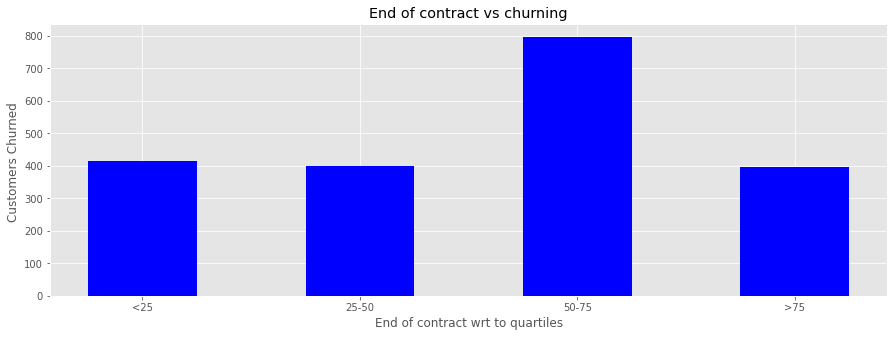

In [ ]:
data_dict = {'<25':bin_25, '25-50':bin_50, '50-75':bin_75, '>75':bin_100 }
courses = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (15, 5))

plt.bar(courses, values, color ='blue',
        width = 0.5)
plt.xlabel("End of contract wrt to quartiles")
plt.ylabel("Customers Churned ")
plt.title("End of contract vs churning")
plt.show()

In [ ]:
#plt.hist(df_train['forecast_price_energy_p1'])

In [ ]:
#plt.scatter(df_train['forecast_price_energy_p1'],df_train['price_p1_fix'])

In [ ]:
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit


In [ ]:
include = [cols for cols in df_train.columns if np.issubdtype(df_train[cols].dtype,np.number) and cols!='churn']
for col in include:
#  print(col)
  upper, lower = outliers(df_train, col)
  new_df = df_train[(df_train[col] > lower) & (df_train[col] < upper)]



In [ ]:
#df_train.columns

In [ ]:
#new_df.columns

In [ ]:
new_df.shape

(0, 23)

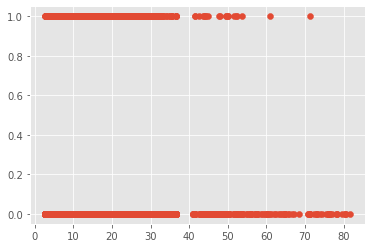

In [ ]:
plt.scatter(df_train['date_renewal'],df_train['churn'])

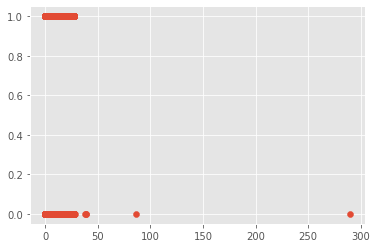

In [ ]:
plt.scatter(df_train['date_end'],df_train['churn'])

In [ ]:
y = df_train['churn']
X = df_train.drop('churn',axis=1)

In [ ]:
#y = new_df['churn']
#X = new_df.drop('churn',axis=1)

## PCA

In [ ]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)

In [ ]:
explained_variance = pca.explained_variance_ratio_

In [ ]:
np.sum(explained_variance)

0.9980808585428562

In [ ]:
principals_composition = abs(pca.components_)

In [ ]:
principals_composition.shape

(2, 20)

In [ ]:
explained_variance

array([0.94978676, 0.0482941 ])

In [ ]:
normalized_pc2 = principals_composition[1]/np.sum(principals_composition[1])
v2 = np.sort(normalized_pc2)[::-1]
summation = np.sum(v2[:10])
print(summation)

0.999996688768649


In [ ]:
normalized_pc1 = principals_composition[0]/np.sum(principals_composition[0])

In [ ]:
v1 = np.sort(normalized_pc1)[::-1]

In [ ]:
summation = np.sum(v1[:10])
summation

0.9999984476496643

In [ ]:
featureimp_dict2 = {'Normalized_PC':normalized_pc2, 'feature_names':X.columns}
df_featureimp2 = pd.DataFrame(featureimp_dict2)
features_rank2 = df_featureimp2.sort_values(by='Normalized_PC',ascending=False)

In [ ]:
featureimp_dict1 = {'Normalized_PC':normalized_pc1, 'feature_names':X.columns}
df_featureimp1 = pd.DataFrame(featureimp_dict1)
features_rank1 = df_featureimp1.sort_values(by='Normalized_PC',ascending=False)

In [ ]:
print(features_rank1,'\n\n\n',features_rank2)

    Normalized_PC             feature_names
0    8.041629e-01                  cons_12m
1    1.044665e-01              cons_gas_12m
2    9.050833e-02           cons_last_month
6    7.870723e-04         forecast_cons_12m
14   5.306303e-05                net_margin
7    8.049438e-06   forecast_meter_rent_12m
4    6.595111e-06           date_modif_prod
15   2.645669e-06                   pow_max
12   1.727213e-06        margin_net_pow_ele
11   1.543439e-06      margin_gross_pow_ele
13   5.417992e-07               nb_prod_act
5    4.422341e-07              date_renewal
3    3.513012e-07                date_activ
10   1.093484e-07                   has_gas
16   4.259137e-08                   origin2
19   2.726115e-08            channel_sales8
18   1.560614e-08            channel_sales2
17   1.277996e-08                   origin3
9    8.388222e-09  forecast_price_energy_p2
8    1.040647e-09  forecast_price_energy_p1 


     Normalized_PC             feature_names
1    8.790708e-01           

## Model

In [ ]:
#exclude = ['cons_12m','cons_gas_12m','cons_last_month','forecast_cons_year','forecast_cons_12m','imp_cons','net_margin','date_modif_prod','forecast_meter_rent_12m','pow_max','margin_net_pow_ele','margin_gross_pow_ele','price_p1_fix','forecast_discount_energy','date_activ','price_p2_var','forecast_price_energy_p1']

In [ ]:
model_log = LogisticRegression(solver='liblinear', random_state=0)
#sm = SMOTE(sampling_strategy=0.2,random_state = 33)
model = xgb.XGBClassifier(learning_rate=0.1,max_depth=10,n_estimators=200,scale_pos_weight=40,n_jobs=-1,use_label_encoder=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 2, shuffle = True, stratify = y)
#X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())
model.fit(X_train,y_train)
#model_log.fit(X_train_new,y_train_new)
#model_log.fit(X_train,y_train)
#model.fit(X_train_new,y_train_new)
#train_log_preds = model.predict(X_train)
#train_log_preds = model.predict(X_train_new)
#test_log_preds = model.predict(X_test)
#train_log_preds = model_log.predict(X_train)
#test_log_preds = model_log.predict(X_test)

train_log_preds = model.predict(X_train)
test_log_preds = model.predict(X_test)
y_train_new = y_train


train_metrics = {'train_acc': metrics.accuracy_score(y_train_new, train_log_preds),
'train_conf': confusion_matrix(y_train_new, train_log_preds),
'train_precision': metrics.precision_score(y_train_new, train_log_preds),
'train_recall': metrics.recall_score(y_train_new, train_log_preds),
'train_roc': roc_auc_score(y_train_new, train_log_preds)}

test_metrics = {'test_acc': metrics.accuracy_score(y_test,test_log_preds),
'test_conf': confusion_matrix(y_test,test_log_preds),
'test_precision': metrics.precision_score(y_test,test_log_preds),
'test_recall': metrics.recall_score(y_test,test_log_preds),
'test_roc': roc_auc_score(y_test,test_log_preds)}


In [ ]:
train_metrics

{'train_acc': 0.9893690459754245, 'train_conf': array([[12897,   154],
        [    0,  1435]]), 'train_precision': 0.9030837004405287, 'train_recall': 1.0, 'train_roc': 0.994100068960233}

In [ ]:
test_metrics

{'test_acc': 0.8782608695652174, 'test_conf': array([[1358,   92],
        [ 104,   56]]), 'test_precision': 0.3783783783783784, 'test_recall': 0.35, 'test_roc': 0.6432758620689656}

In [ ]:
test_conf = np.array([[1032,  128],
        [  68,   60]])

In [ ]:
best_test_metrics = {'test_acc': 0.84, 'test_precision': 0.32, 'test_recall': 0.47, 'test_roc': 0.68}

In [ ]:
best_test_metrics

{'test_acc': 0.84,
 'test_precision': 0.32,
 'test_recall': 0.47,
 'test_roc': 0.68}

## Feature inspection by permutation

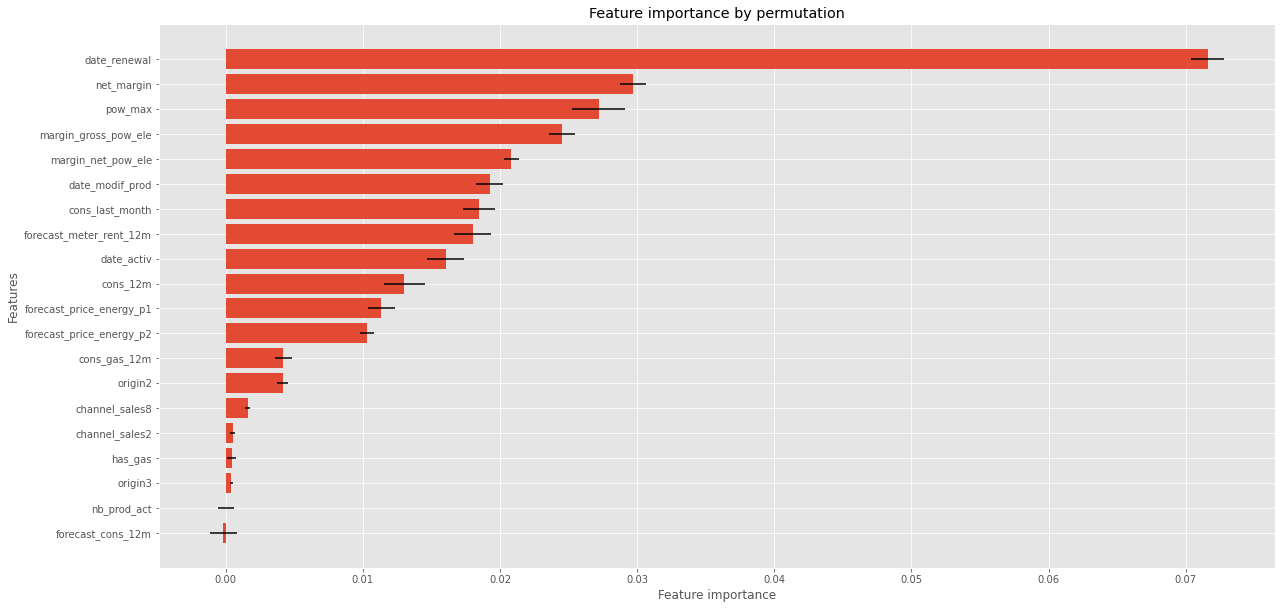

In [ ]:
from sklearn.inspection import permutation_importance

def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(20,10))

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.title("Feature importance by permutation")
    plt.savefig('/content/drive/MyDrive/Takehome-pipecandy/pics/New/feature_permutation23.png')

    
perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=5)

plot_feature_importances(perm_importance_result_train, X_train.columns)

## Rough

In [ ]:
['cons_12m','margin_net_pow_ele','net_margin','forecast_meter_rent_12m','margin_gross_pow_ele','date_activ','pow_max','cons_last_month','date_modif_prod','date_renewal']

['cons_12m',
 'margin_net_pow_ele',
 'net_margin',
 'forecast_meter_rent_12m',
 'margin_gross_pow_ele',
 'date_activ',
 'pow_max',
 'cons_last_month',
 'date_modif_prod',
 'date_renewal']